#Table of Contents
* [Set Up](#Set-Up)
	* [Sampling, timing, and look up table](#Sampling,-timing,-and-look-up-table)
	* [Function to apply FIR filter given coefficient & delay line arrays](#Function-to-apply-FIR-filter-given-coefficient-&-delay-line-arrays)
* [Filter coefficients](#Filter-coefficients)
	* [Low pass filter](#Low-pass-filter)
	* [Bandpass filter](#Bandpass-filter)
* [Test low pass filter](#Test-low-pass-filter)
	* [DC signal](#DC-signal)
	* [1 kHz cosine](#1-kHz-cosine)
	* [1 kHz cosine with offset](#1-kHz-cosine-with-offset)
* [Test bandpass filter](#Test-bandpass-filter)
	* [DC signal](#DC-signal)
	* [1 kHz cosine](#1-kHz-cosine)
		* [Normalize bandpass filter output](#Normalize-bandpass-filter-output)
		* [Shift output of bandpass filtered output to get rid of phase shift](#Shift-output-of-bandpass-filtered-output-to-get-rid-of-phase-shift)
* [Normalize band pass filter output the correct way](#Normalize-band-pass-filter-output-the-correct-way)
	* [Function to calculate filter gain at specific frequency](#Function-to-calculate-filter-gain-at-specific-frequency)
	* [Normalize filter coefficients](#Normalize-filter-coefficients)
	* [Test using normalized coefficients](#Test-using-normalized-coefficients)
		* [1 kHz cosine](#1-kHz-cosine)
		* [DC signal](#DC-signal)
* [Develop functions to apply zero-phase FIR filter with normalized coefficients to entire array of data](#Develop-functions-to-apply-zero-phase-FIR-filter-with-normalized-coefficients-to-entire-array-of-data)
	* [Function definitions](#Function-definitions)
	* [Test function that acts on individual position in input data array](#Test-function-that-acts-on-individual-position-in-input-data-array)
	* [Test function that acts on entire data array](#Test-function-that-acts-on-entire-data-array)


In [1]:
%%javascript
IPython.load_extensions('calico-document-tools');

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
from __future__ import print_function
from scipy import signal

# Set Up 

## Sampling, timing, and look up table

cosine freq = 1000.0 Hz
sampling freq = 10000.0 Hz
cosine look up table:
 [ 1.          0.80901699  0.30901699 -0.30901699 -0.80901699 -1.
 -0.80901699 -0.30901699  0.30901699  0.80901699]


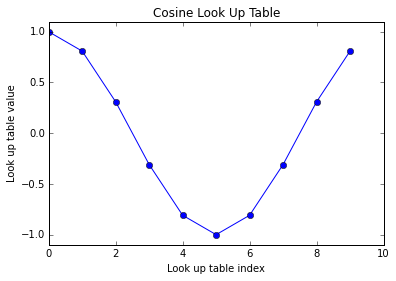

In [3]:
t_inter = 100
n_samp_cos = 10
freq_samp = 1.0/((t_inter*1e-6))
freq_cos = 1.0/((t_inter*1e-6)*n_samp_cos)
print('cosine freq =', freq_cos, 'Hz')
print('sampling freq =', freq_samp, 'Hz')

lut = np.zeros(n_samp_cos)
lut = np.cos(2.0*np.pi*np.arange(n_samp_cos)/n_samp_cos)
print('cosine look up table:\n', lut)

fig, ax = plt.subplots()
ax.plot(range(n_samp_cos), lut, 'o-')
ax.set_xlim(0 ,n_samp_cos)
ax.set_ylim(-1.1, 1.1)
ax.set_title('Cosine Look Up Table')
ax.set_xlabel('Look up table index')
ax.set_ylabel('Look up table value');

## Function to apply FIR filter given coefficient & delay line arrays

In [4]:
def fir_basic(new_value, h, buf):
    '''Calculate FIR filtered value given filter coefficients, h, and delay line, buf
    
       inputs:
           new_value - latest sample
           h - array of filter coefficients
           buf - array containing previous sample values. Should be equal in length to h
       returns:
           new filtered value'''
    num_coef = len(h)
    buf[0] = new_value
    accum = 0
    for i in range(num_coef):
        accum += h[i] * buf[i]
    # shift values to right in z buffer
    for i in range(num_coef-2, -1, -1):
        buf[i+1] = buf[i]
    #print(z, '\n', h)
    return accum

def zero_buf(buf):
    '''Zero all elements of input array'''
    buf = 0.0

# Filter coefficients

## Low pass filter

Calculate coefficients from [FIR Filter Design](http://www.arc.id.au/FilterDesign.html) for Kaiser-Bessel filter generator with the following parameters for a low pass filter: Fa = 0 Hz, Fb = 100 Hz, M(odd) length = 37, dF/2 is 503 Hz (given by calculator), Fs = 10 kHz, Att = 60 dB

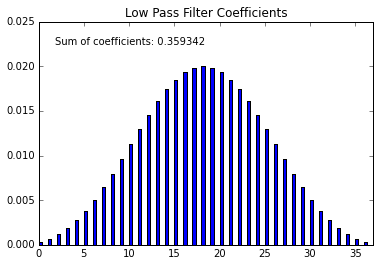

In [5]:
lp_coef = [0.000326, 0.000692, 0.001207, 0.001891, 0.002756, 
           0.003806, 0.005036, 0.006430, 0.007961, 0.009591, 
           0.011275, 0.012958, 0.014582, 0.016086, 0.017413, 
           0.018507, 0.019325, 0.019829, 0.020000, 0.019829, 
           0.019325, 0.018507, 0.017413, 0.016086, 0.014582, 
           0.012958, 0.011275, 0.009591, 0.007961, 0.006430, 
           0.005036, 0.003806, 0.002756, 0.001891, 0.001207, 0.000692, 0.000326]
n_coef = len(lp_coef)
buf = np.zeros(n_coef)
# plot filter coefficients
ind = np.arange(n_coef)
fig, ax = plt.subplots()
ax.bar(ind, lp_coef, 0.35)
ax.set_xlim(0,37)
temptext = 'Sum of coefficients: {}'.format(np.sum(lp_coef))
ax.text(0.05, 0.9, temptext, transform = ax.transAxes)
ax.set_title('Low Pass Filter Coefficients');

## Bandpass filter

Calculate coefficients from [FIR Filter Design](http://www.arc.id.au/FilterDesign.html) for Kaiser-Bessel filter generator with the following parameters for a bandpass filter: Fa = 950 Hz, Fb = 1050 Hz, M(odd) length = 37, dF/2 is 503 Hz (given by calculator), Fs = 10 kHz, Att = 60 dB

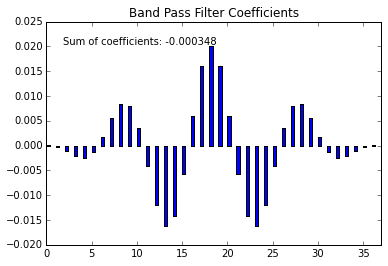

In [6]:
bp_coef = [0.000119, -0.000248, -0.001115, -0.002123, -0.002464, 
           -0.001282, 0.001674, 0.005529, 0.008370, 0.008080, 
           0.003597, -0.004103, -0.012010, -0.016287, -0.014199, 
           -0.005745, 0.005983, 0.016050, 0.020000, 0.016050, 
           0.005983, -0.005745, -0.014199, -0.016287, -0.012010, 
           -0.004103, 0.003597, 0.008080, 0.008370, 0.005529, 
           0.001674, -0.001282, -0.002464, -0.002123, -0.001115, -0.000248, 0.000119] 
if len(bp_coef) != len(lp_coef):
    print('LOW PASS & BAND PASS FILTERS ARE NOT THE SAME LENGTH')
# plot filter coefficients
ind = np.arange(n_coef)
fig, ax = plt.subplots()
ax.bar(ind, bp_coef, 0.35)
ax.set_xlim(0,37)
temptext = 'Sum of coefficients: {}'.format(np.sum(bp_coef))
ax.text(0.05, 0.9, temptext, transform = ax.transAxes)
ax.set_title('Band Pass Filter Coefficients');

# Test low pass filter

In [7]:
n_total_samples = 201
time_dac_output_ms = 1.0e-3 * np.linspace(0, t_inter*(n_total_samples-1), n_total_samples)
print(time_dac_output_ms[0:5])
print(time_dac_output_ms[-5:])
ms_to_s = 1.0e-3

[ 0.   0.1  0.2  0.3  0.4]
[ 19.6  19.7  19.8  19.9  20. ]


## DC signal

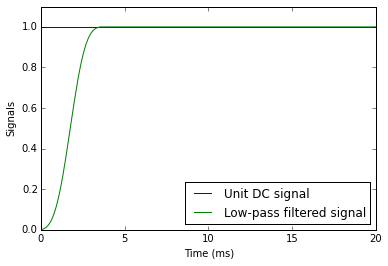

In [8]:
dc_signal = np.ones(n_total_samples)
dc_lp_out = np.zeros(n_total_samples)
delay_line = np.zeros(len(lp_coef))
for i in range(n_total_samples):
    dc_lp_out[i] = fir_basic(dc_signal[i], lp_coef, delay_line)
correction_factor = np.sum(lp_coef)   
dc_lp_out /= correction_factor        # divide result by sum of coefficients to get actual DC value of cosine

fig, ax = plt.subplots()
ax.plot(time_dac_output_ms, dc_signal, label='Unit DC signal')
ax.plot(time_dac_output_ms, dc_lp_out, label='Low-pass filtered signal')
ax.legend(loc=4)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals');

## 1 kHz cosine

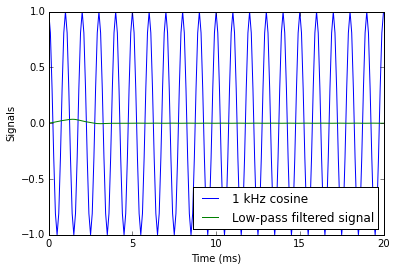

In [9]:
test_freq = 1000.0
cos_1kHz = np.cos(2.0*np.pi*test_freq*(time_dac_output_ms * ms_to_s))
cos_1kHz_lp_out = np.zeros(n_total_samples)
delay_line = np.zeros(len(lp_coef))
for i in range(n_total_samples):
    cos_1kHz_lp_out[i] = fir_basic(cos_1kHz[i], lp_coef, delay_line)
correction_factor = np.sum(lp_coef)   
cos_1kHz_lp_out /= correction_factor        # divide result by sum of coefficients to get actual DC value

fig, ax = plt.subplots()
ax.plot(time_dac_output_ms, cos_1kHz, label='1 kHz cosine')
ax.plot(time_dac_output_ms, cos_1kHz_lp_out, label='Low-pass filtered signal')
ax.legend(loc=4)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals');

In [10]:
print(cos_1kHz_lp_out[-10:])

[ 0.00017832  0.00046686  0.00057707  0.00046686  0.00017832 -0.00017832
 -0.00046686 -0.00057707 -0.00046686 -0.00017832]


## 1 kHz cosine with offset

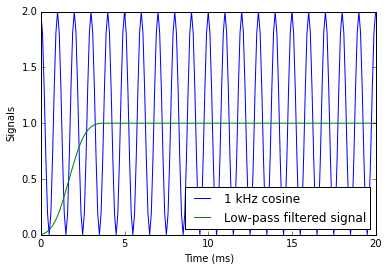

In [11]:
offset = 1.0
test_freq = 1000.0
cos_1kHz_offset = np.cos(2.0*np.pi*test_freq*(time_dac_output_ms * ms_to_s)) + offset
cos_1kHz_offset_lp_out = np.zeros(n_total_samples)
delay_line = np.zeros(len(lp_coef))
for i in range(n_total_samples):
    cos_1kHz_offset_lp_out[i] = fir_basic(cos_1kHz_offset[i], lp_coef, delay_line)
correction_factor = np.sum(lp_coef)   
cos_1kHz_offset_lp_out /= correction_factor        # divide result by sum of coefficients to get actual DC value

fig, ax = plt.subplots()
ax.plot(time_dac_output_ms, cos_1kHz_offset, label='1 kHz cosine')
ax.plot(time_dac_output_ms, cos_1kHz_offset_lp_out, label='Low-pass filtered signal')
ax.legend(loc=4)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals');

In [12]:
print(cos_1kHz_offset_lp_out[-10:])

[ 1.00017832  1.00046686  1.00057707  1.00046686  1.00017832  0.99982168
  0.99953314  0.99942293  0.99953314  0.99982168]


# Test bandpass filter

In [13]:
n_total_samples = 201
time_dac_output_ms = 1.0e-3 * np.linspace(0, t_inter*(n_total_samples-1), n_total_samples)
print(time_dac_output_ms[0:5])
print(time_dac_output_ms[-5:])
ms_to_s = 1.0e-3

[ 0.   0.1  0.2  0.3  0.4]
[ 19.6  19.7  19.8  19.9  20. ]


## DC signal

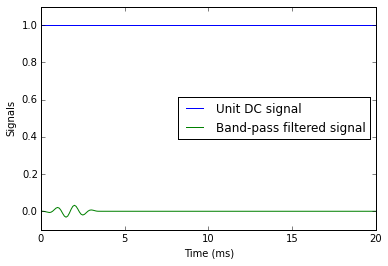

In [14]:
dc_signal = np.ones(n_total_samples)
dc_bp_out = np.zeros(n_total_samples)
delay_line = np.zeros(len(lp_coef))
for i in range(n_total_samples):
    dc_bp_out[i] = fir_basic(dc_signal[i], bp_coef, delay_line)
correction_factor = np.sum(bp_coef)   
#dc_bp_out /= correction_factor        # divide result by sum of coefficients to get actual DC value of cosine

fig, ax = plt.subplots()
ax.plot(time_dac_output_ms, dc_signal, label='Unit DC signal')
ax.plot(time_dac_output_ms, dc_bp_out, label='Band-pass filtered signal')
ax.legend(loc=7)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals');

## 1 kHz cosine

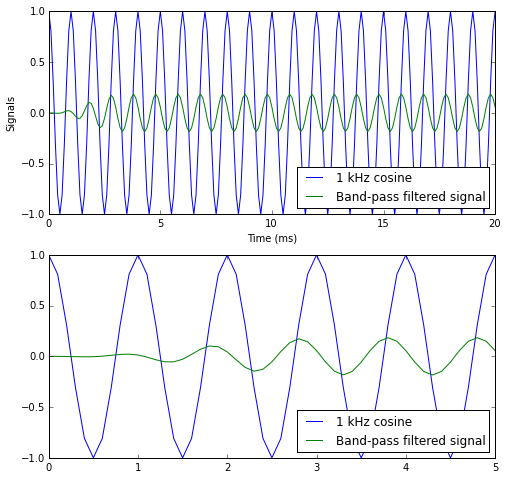

In [15]:
test_freq = 1000.0
cos_1kHz = np.cos(2.0*np.pi*test_freq*(time_dac_output_ms * ms_to_s))
cos_1kHz_bp_out = np.zeros(n_total_samples)
delay_line = np.zeros(len(lp_coef))
for i in range(n_total_samples):
    cos_1kHz_bp_out[i] = fir_basic(cos_1kHz[i], bp_coef, delay_line)

fig, (ax, ax2) = plt.subplots(2, figsize=(8,8))
ax.plot(time_dac_output_ms, cos_1kHz, label='1 kHz cosine')
ax.plot(time_dac_output_ms, cos_1kHz_bp_out, label='Band-pass filtered signal')
ax.legend(loc=4)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals')
ax2.plot(time_dac_output_ms, cos_1kHz, label='1 kHz cosine')
ax2.plot(time_dac_output_ms, cos_1kHz_bp_out, label='Band-pass filtered signal')
ax2.legend(loc=4)
ax2.set_xlim(0,5);

### Normalize bandpass filter output

In [16]:
print(max(cos_1kHz), max(cos_1kHz_bp_out), max(bp_coef))

1.0 0.183808157807 0.02


In [17]:
bp_coef

[0.000119,
 -0.000248,
 -0.001115,
 -0.002123,
 -0.002464,
 -0.001282,
 0.001674,
 0.005529,
 0.00837,
 0.00808,
 0.003597,
 -0.004103,
 -0.01201,
 -0.016287,
 -0.014199,
 -0.005745,
 0.005983,
 0.01605,
 0.02,
 0.01605,
 0.005983,
 -0.005745,
 -0.014199,
 -0.016287,
 -0.01201,
 -0.004103,
 0.003597,
 0.00808,
 0.00837,
 0.005529,
 0.001674,
 -0.001282,
 -0.002464,
 -0.002123,
 -0.001115,
 -0.000248,
 0.000119]

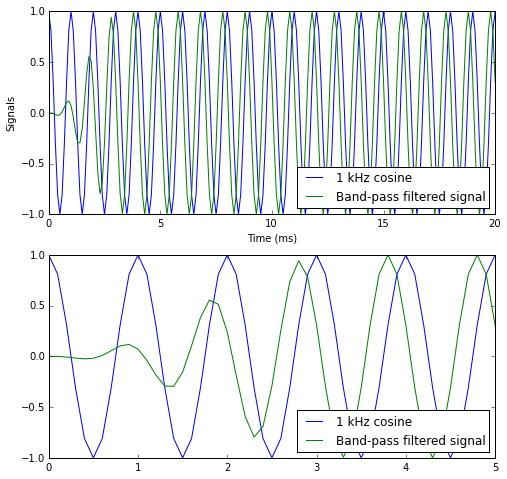

In [21]:
fig, (ax, ax2) = plt.subplots(2, figsize=(8,8))
ax.plot(time_dac_output_ms, cos_1kHz, label='1 kHz cosine')
ax.plot(time_dac_output_ms, cos_1kHz_bp_out/max(cos_1kHz_bp_out), label='Band-pass filtered signal')
ax.legend(loc=4)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals')
ax2.plot(time_dac_output_ms, cos_1kHz, label='1 kHz cosine')
ax2.plot(time_dac_output_ms, cos_1kHz_bp_out/max(cos_1kHz_bp_out), label='Band-pass filtered signal')
ax2.legend(loc=4)
ax2.set_xlim(0,5);

### Shift output of bandpass filtered output to get rid of phase shift

In [30]:
shifted = np.zeros(n_total_samples)
phase_shift_index = int((n_coef-1)/2)
print(phase_shift_index)
for i in range(n_total_samples-phase_shift_index):
    shifted[i] = cos_1kHz_bp_out[i+phase_shift_index]

18


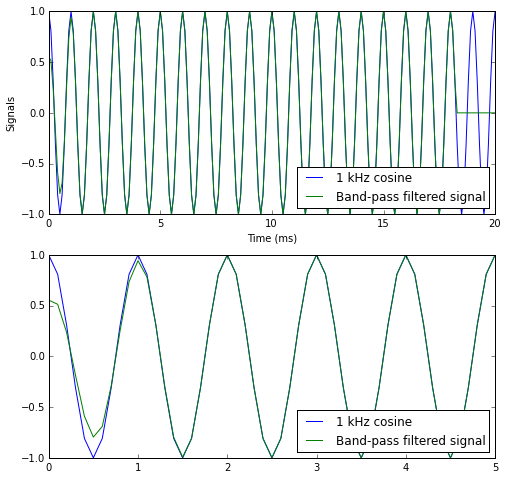

In [31]:
fig, (ax, ax2) = plt.subplots(2, figsize=(8,8))
ax.plot(time_dac_output_ms, cos_1kHz, label='1 kHz cosine')
ax.plot(time_dac_output_ms, shifted/max(cos_1kHz_bp_out), label='Band-pass filtered signal')
ax.legend(loc=4)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals')
ax2.plot(time_dac_output_ms, cos_1kHz, label='1 kHz cosine')
ax2.plot(time_dac_output_ms, shifted/max(cos_1kHz_bp_out), label='Band-pass filtered signal')
ax2.legend(loc=4)
ax2.set_xlim(0,5);

In [48]:
print('phase shift is', max(time_dac_output_ms)*phase_shift_index/(201-1), 
      'ms, which is', phase_shift_index, 'index positions')

phase shift is 1.8 ms, which is 18 index positions


# Normalize band pass filter output the correct way

See answer at [this stackexchange question](http://dsp.stackexchange.com/questions/4693/fir-filter-gain). However, the gain is complex so let's use the method suggested by Jerry Avins in a post at [dsprelated.com](http://www.dsprelated.com/showthread/comp.dsp/8245-1.php) near the bottom of page 1. [This post](http://www.dsprelated.com/showthread/comp.dsp/118528-1.php) says that scaling doesn't really matter.

Stackexchange:

\begin{equation}
  G = \sum_k^{N-1} h[k]e^{-j\omega k}
\end{equation}

dsprelated.com:

\begin{align}
  G &= \left|\sum_k^{N-1} h[k]e^{-j\omega k}\right| \\
  &= \left|\sum_k^{N-1} h[k]\big[\cos(\omega k) - j \sin(\omega k)\big] \right| \\
  &= \left|\sum_k^{N-1} h[k]\cos(\omega k) - j \sum_k^{N-1} h[k]\sin(\omega k) \right| \\  
  &= \sqrt{\left(\sum_k^{N-1} h[k]\cos(\omega k)\right)^2 + \left(\sum_k^{N-1} h[k]\sin(\omega k)\right)^2 } \\  
\end{align}

Stackexchange says, "_G gives the gain of your filter at the frequency $\omega \in [0,2\pi)$._" I assume this means you choose $\omega = 2\pi\frac{f_{carrier}}{f_{sampling}}$ which in our case is $\omega = 2\pi\frac{1 \text{kHz}}{10 \text{kHz}} = 2\pi(0.1)$

In [37]:
omega = 2.0*np.pi * (1.0/10)
print(omega)

0.628318530718


## Function to calculate filter gain at specific frequency

In [38]:
def gain_magn(h, omega):
    cos_term, sin_term = 0.0, 0.0
    for k in range(len(h)):
        cos_term += h[k] * np.cos(2.0*np.pi*omega*k)
        sin_term += h[k] * np.sin(2.0*np.pi*omega*k)
    gain_mag = np.sqrt( cos_term**2 + sin_term**2 )
    return gain_mag

In [41]:
print(gain_magn(bp_coef, 0.1))
print(max(cos_1kHz_bp_out))

0.183808157807
0.183808157807


Yes, this calculation of the gain appears to work just fine!

In [42]:
print(gain_magn(lp_coef, 0.0))
print(np.sum(lp_coef))

0.359342
0.359342


It also works for the low pass filter. I'm therefore going to normalize the coefficients:

## Normalize filter coefficients

In [43]:
lp_coef_norm = lp_coef/gain_magn(lp_coef, 0.0)
bp_coef_norm = bp_coef/gain_magn(bp_coef, 0.1)

## Test using normalized coefficients

### 1 kHz cosine

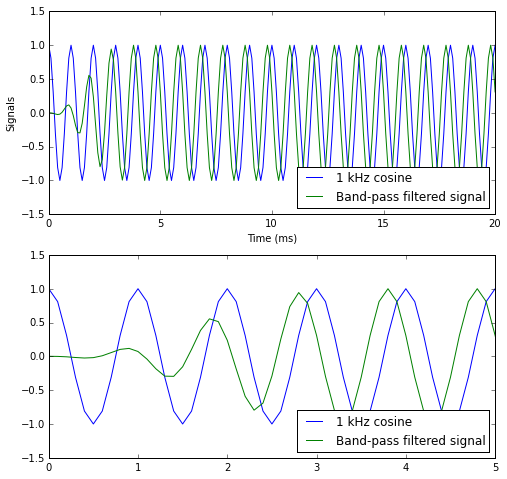

In [44]:
test_freq = 1000.0
cos_1kHz = np.cos(2.0*np.pi*test_freq*(time_dac_output_ms * ms_to_s))
cos_1kHz_bp_out = np.zeros(n_total_samples)
delay_line = np.zeros(len(lp_coef))
for i in range(n_total_samples):
    cos_1kHz_bp_out[i] = fir_basic(cos_1kHz[i], bp_coef_norm, delay_line)

fig, (ax, ax2) = plt.subplots(2, figsize=(8,8))
ax.plot(time_dac_output_ms, cos_1kHz, label='1 kHz cosine')
ax.plot(time_dac_output_ms, cos_1kHz_bp_out, label='Band-pass filtered signal')
ax.legend(loc=4)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals')
ax2.plot(time_dac_output_ms, cos_1kHz, label='1 kHz cosine')
ax2.plot(time_dac_output_ms, cos_1kHz_bp_out, label='Band-pass filtered signal')
ax2.legend(loc=4)
ax2.set_xlim(0,5);

### DC signal

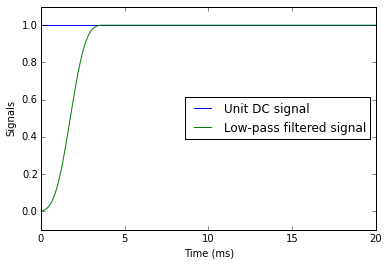

In [47]:
dc_signal = np.ones(n_total_samples)
dc_bp_out = np.zeros(n_total_samples)
delay_line = np.zeros(len(lp_coef))
for i in range(n_total_samples):
    dc_bp_out[i] = fir_basic(dc_signal[i], lp_coef_norm, delay_line)

fig, ax = plt.subplots()
ax.plot(time_dac_output_ms, dc_signal, label='Unit DC signal')
ax.plot(time_dac_output_ms, dc_bp_out, label='Low-pass filtered signal')
ax.legend(loc=7)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals');

# Develop functions to apply zero-phase FIR filter with normalized coefficients to entire array of data

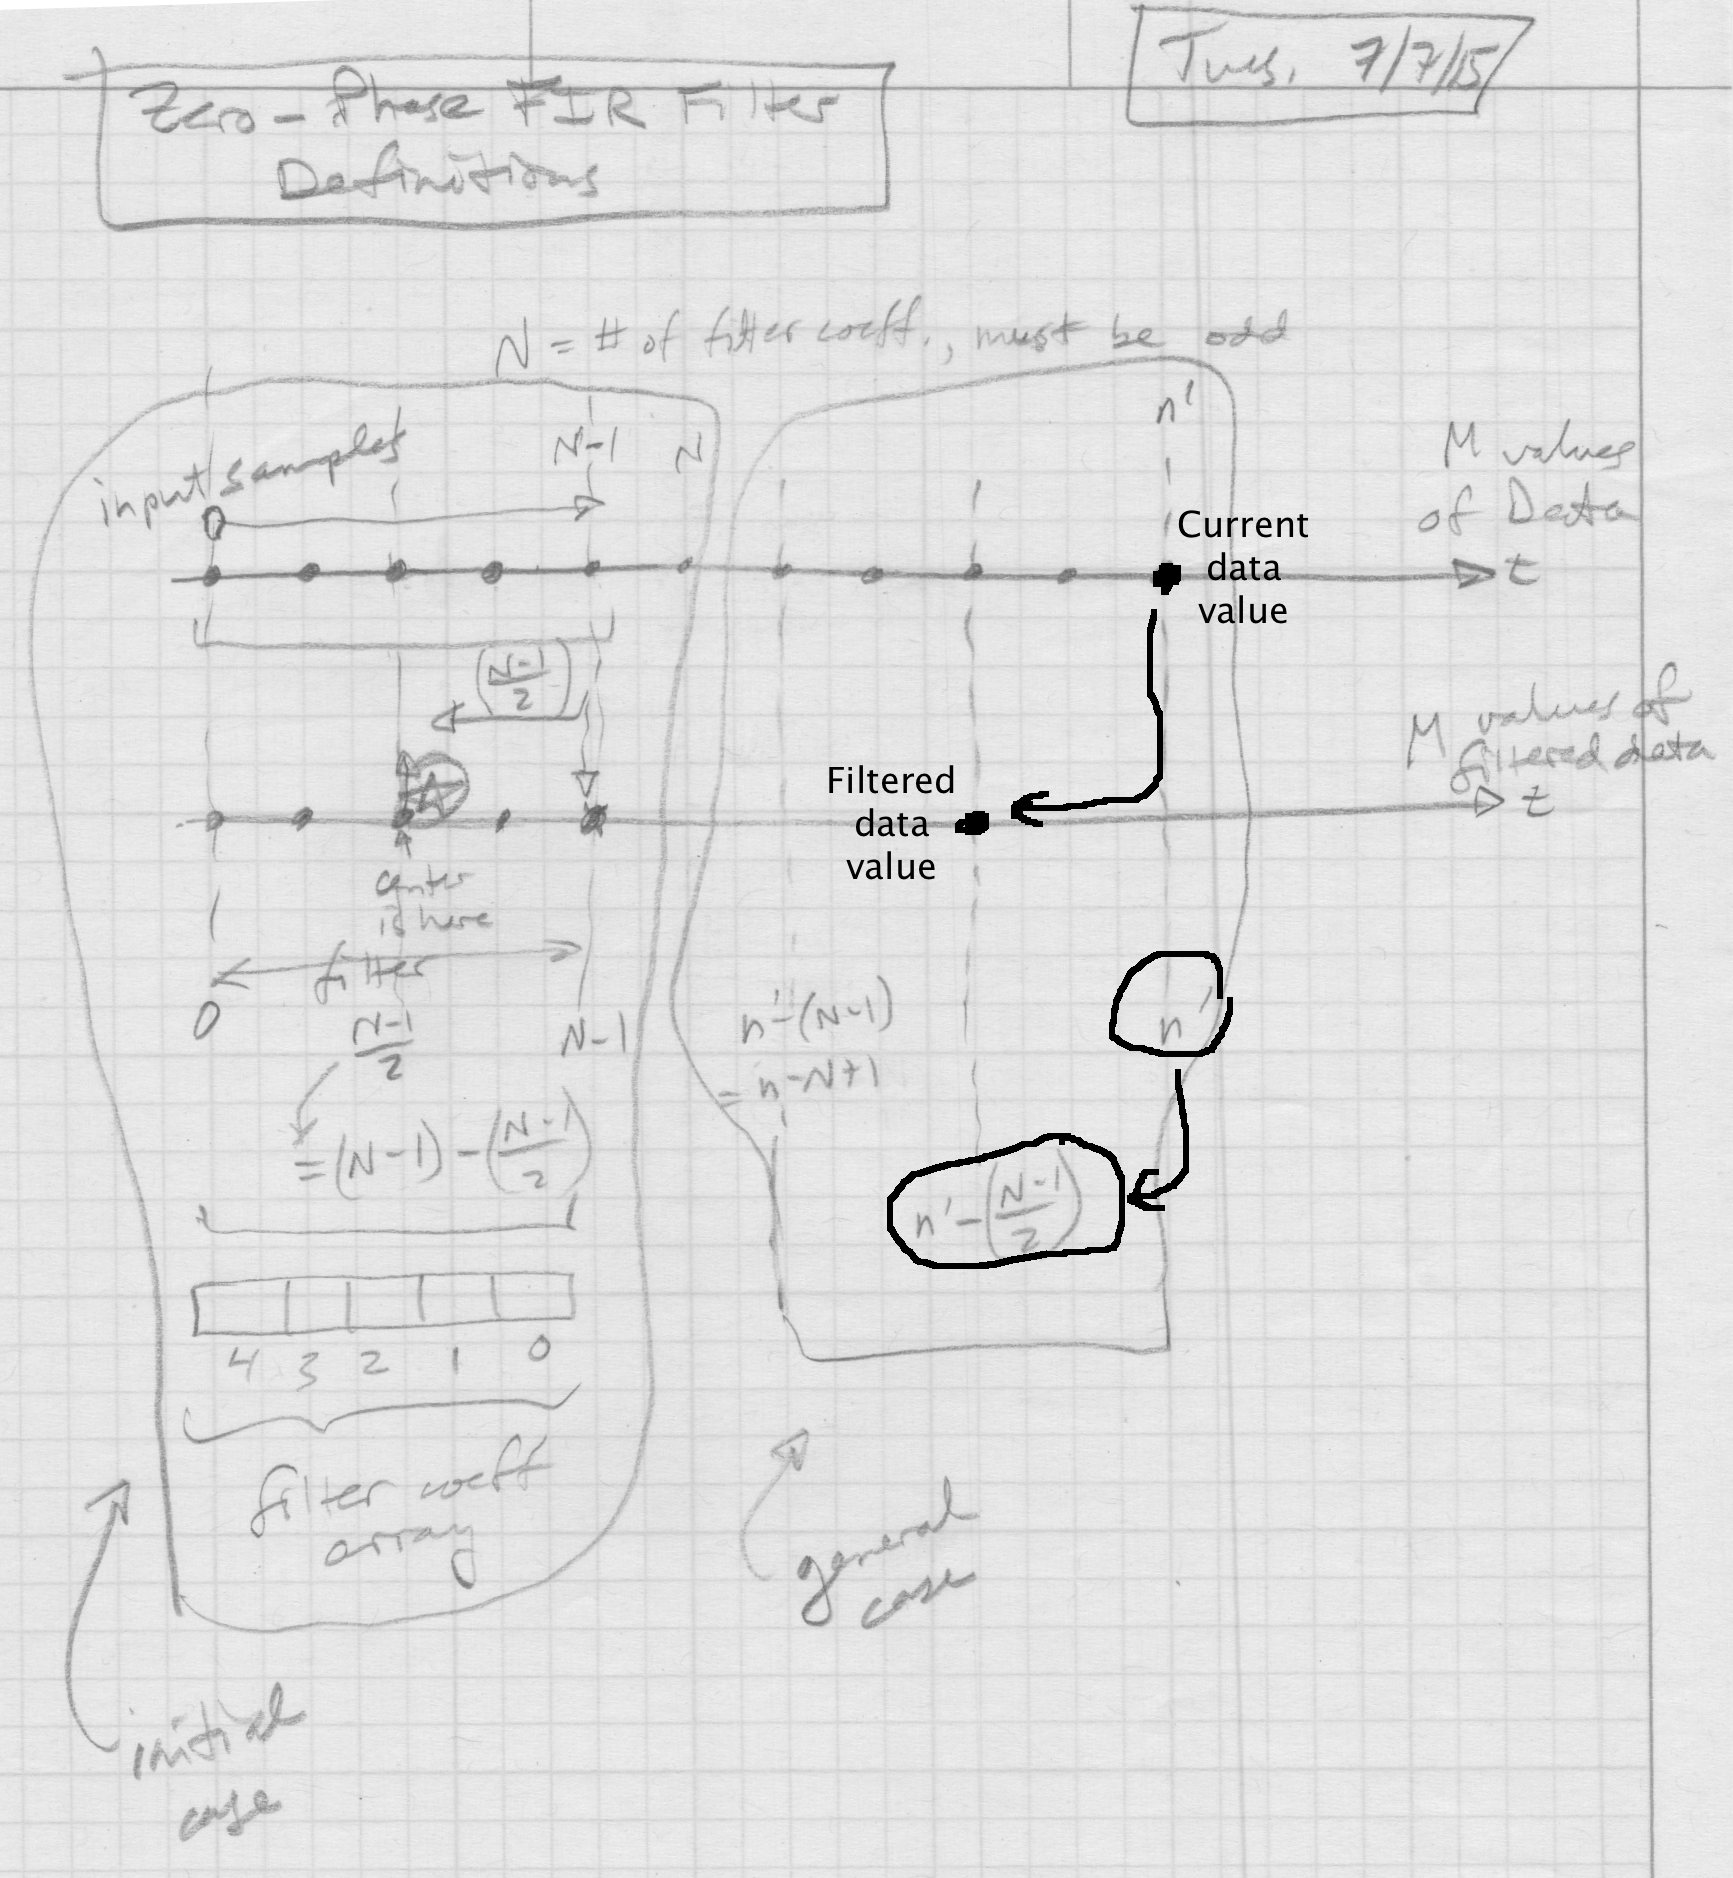

In [77]:
from IPython.display import Image
temp_w = 700
temp_h = temp_w * (1878 / 1733)
Image(filename='150706_zero_phase_FIR_notes.png', width=temp_w, height=temp_h) 

## Function definitions

In [78]:
def fir_on_value_in_array(data_array, ii, h):
    '''Calculate FIR filtered value given filter coefficients, array of data, & current index into array of data
    
       Inputs:
           data_array - array of data values
           ii - index current data_array value for which to calculate filtered value
           h - array of filter coefficients
       Returns:
           new filtered value'''
    num_coef = len(h)
    accum = 0
    for k in range(num_coef):
        accum += h[k] * data_array[ii-k]
    return accum

def zero_phase_fir_on_array(data_array, h):
    '''Apply zero-phase FIR filter to array of data given the FIR filter coefficients. Zero-phase in practice
       means that the filtered data is shifted back in time in the output array by (N-1)/2 where N is the
       number of FIR filter coefficients. N must be odd. The first and last (N-1)/2 - 1 values of the filtered
       data array will be zero. 
    
       Inputs:
           data_array - array of data values to be filtered
           h - array of filter coefficients
       Returns:
           array with filtered values'''
    filtered_data = np.zeros(len(data_array))
    n_coef = len(h)
    n_mid_coef = (n_coef-1)//2
    for i in range(n_coef-1, n_total_samples):
        filtered_data[i-n_mid_coef] = fir_on_value_in_array(data_array, i, h)
    return filtered_data

## Test function that acts on individual position in input data array

37 18


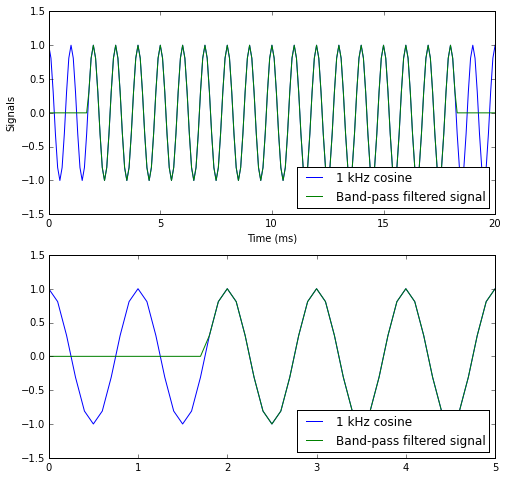

In [79]:
test_freq = 1000.0
cos_1kHz_zeroph = np.cos(2.0*np.pi*test_freq*(time_dac_output_ms * ms_to_s))
cos_1kHz_zeroph_bp_out = np.zeros(n_total_samples)
n_coef = len(bp_coef_norm)
n_mid_coef = (n_coef-1)//2
print(n_coef, n_mid_coef)
for i in range(n_coef-1, n_total_samples):
    cos_1kHz_zeroph_bp_out[i-n_mid_coef] = fir_on_value_in_array(cos_1kHz_zeroph, i, bp_coef_norm)

fig, (ax, ax2) = plt.subplots(2, figsize=(8,8))
ax.plot(time_dac_output_ms, cos_1kHz_zeroph, label='1 kHz cosine')
ax.plot(time_dac_output_ms, cos_1kHz_zeroph_bp_out, label='Band-pass filtered signal')
ax.legend(loc=4)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals')
ax2.plot(time_dac_output_ms, cos_1kHz_zeroph, label='1 kHz cosine')
ax2.plot(time_dac_output_ms, cos_1kHz_zeroph_bp_out, label='Band-pass filtered signal')
ax2.legend(loc=4)
ax2.set_xlim(0,5);

## Test function that acts on entire data array

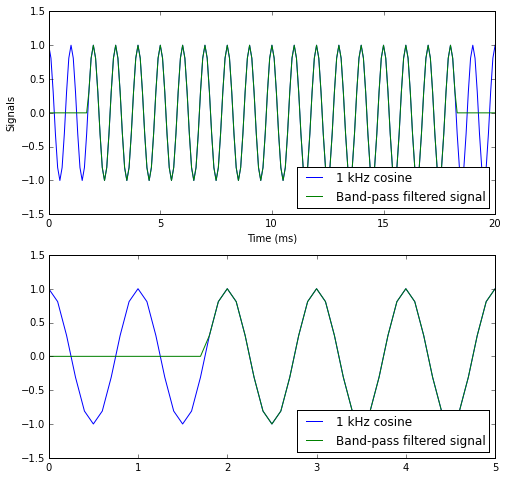

In [80]:
test_freq = 1000.0
cos_1kHz_zeroph = np.cos(2.0*np.pi*test_freq*(time_dac_output_ms * ms_to_s))
cos_1kHz_zeroph_bp_out = zero_phase_fir_on_array(cos_1kHz_zeroph, bp_coef_norm)

fig, (ax, ax2) = plt.subplots(2, figsize=(8,8))
ax.plot(time_dac_output_ms, cos_1kHz_zeroph, label='1 kHz cosine')
ax.plot(time_dac_output_ms, cos_1kHz_zeroph_bp_out, label='Band-pass filtered signal')
ax.legend(loc=4)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals')
ax2.plot(time_dac_output_ms, cos_1kHz_zeroph, label='1 kHz cosine')
ax2.plot(time_dac_output_ms, cos_1kHz_zeroph_bp_out, label='Band-pass filtered signal')
ax2.legend(loc=4)
ax2.set_xlim(0,5);

In [62]:
print(cos_1kHz_zeroph_bp_out[-20:])

[ 0.80901699  0.30901699  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


In [63]:
print(cos_1kHz_zeroph_bp_out[:20])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.30901699  0.80901699]
